# Introduction

This project was created as part of learning at the Sages DataScience bootcamp.
The aim of this project is to build an effective model that recognizes numbers shown in sign language and to compare two different optimizers with each other - convolutional network parameters.

## Database origin

The database was created on the initiative of Turkey Ankara Ayrancı Anadolu High School Students. Each of the 218 students made 10 signs with their hands that were photographed for educational purposes. The repository and the full description have been placed in the repo on kaggle. [1]

## Approaches used

The following approach proposes to use a deep learning net derived from the Keras python library. This library was chosen for its user-friendliness and the effects it gives on small, typical collections, such as the Sign Language Digits Dataset. The optmizers that will be compared are: Adam - one of the most commonly used optimizers with the opinion of versatile and fast, and RMSProp, similar to Adam, but does not use cumulative history of gradients. [2] The rest of the parameters have not been changed.


# Code

## Importing the libraries

In [1]:
import os
import time
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns

import tensorflow as tf

import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Input, Flatten, Conv2D, MaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, Callback
from tensorflow.keras.optimizers import RMSprop,Adam
from sklearn.utils import class_weight

## Importing the database

In order to download the database, first place it on the disk using the URL address provided in the description and refer to the appropriate paths in the cell below.

In [2]:
x = np.load("C:/Users/Izabela/Desktop/projectSages/sign_language_digits/X.npy")
y = np.load("C:/Users/Izabela/Desktop/projectSages/sign_language_digits/Y.npy")

## Preview files for analysis 

(-0.5, 63.5, 63.5, -0.5)

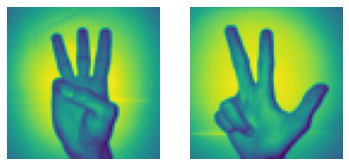

In [3]:
img_size = 64
plt.subplot(1,2,1)
plt.imshow(x[700].reshape(img_size,img_size))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(x[1500].reshape(img_size,img_size))
plt.axis('off')

## Check if files already have labels and scaled features

In [4]:
# The labels are already one hot encoded
print(y.max())
print(y.min())
print(y.shape)

# The features are already scaled between 0 and 1
print(x.max())
print(x.min())
print(x.shape)

1.0
0.0
(2062, 10)
1.0
0.003921569
(2062, 64, 64)


## Division of files into test and training samples

In [5]:
# Now,lets create x_train, y_train, x_test, y_test arrays
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
#reshape
x_train = x_train.reshape(-1,64,64,1)
x_test = x_test.reshape(-1,64,64,1)
#print x_train and y_train shape
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1649, 64, 64, 1)
(1649, 10)
(413, 64, 64, 1)
(413, 10)


As you can see, the training and test samples have 1649 and 413 images, respectively. The number of classes is 10.

## Building the model

The model is sequential. Full information about its layers can be obtained by running the model.summary () cell

In [6]:
model = Sequential()

model.add(Conv2D(filters = 8, kernel_size = (5,5), padding = 'Same', activation = 'relu', input_shape = (64,64,1)))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))


# fully connected
model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

The flattening the output layer and three dense layers were added to the convolution layers with frequently used 'relu' activation functions. The kernel size was reduced after the first layer due to the already incurred 'losses'.

## A feature that allows you to monitor callbacks after each epoch

In [7]:
def get_checkpoint(model_name):
    checkpoint_path = 'checkpoints/' + model_name + '-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
    return ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=True)

## Model summary

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4

## Initializing Variables 'Optimizers'

In [9]:
optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
optimizer2 = tf.keras.optimizers.RMSprop()

optimizers = [optimizer, optimizer2]

## Functions that record metrics after each epoch

In [10]:
# Helper Functions  Learning Curves and Confusion Matrix

#from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, checkpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)



## Fitting and result display for each optimizer

Epoch 1/100
42/42 [==============================] - 6s 129ms/step - loss: 2.3113 - accuracy: 0.0887 - val_loss: 2.3027 - val_accuracy: 0.0909
Epoch 2/100
42/42 [==============================] - 5s 108ms/step - loss: 2.3022 - accuracy: 0.1092 - val_loss: 2.3027 - val_accuracy: 0.0909
Epoch 3/100
42/42 [==============================] - 5s 109ms/step - loss: 2.2940 - accuracy: 0.1342 - val_loss: 2.2586 - val_accuracy: 0.2758
Epoch 4/100
42/42 [==============================] - 5s 109ms/step - loss: 1.7410 - accuracy: 0.3829 - val_loss: 1.2103 - val_accuracy: 0.5939
Epoch 5/100
42/42 [==============================] - 5s 107ms/step - loss: 1.0489 - accuracy: 0.6232 - val_loss: 0.9924 - val_accuracy: 0.6152
Epoch 6/100
42/42 [==============================] - 5s 108ms/step - loss: 0.8124 - accuracy: 0.7271 - val_loss: 0.6635 - val_accuracy: 0.7606
Epoch 7/100
42/42 [==============================] - 5s 108ms/step - loss: 0.6491 - accuracy: 0.7809 - val_loss: 0.5298 - val_accuracy: 0.8273

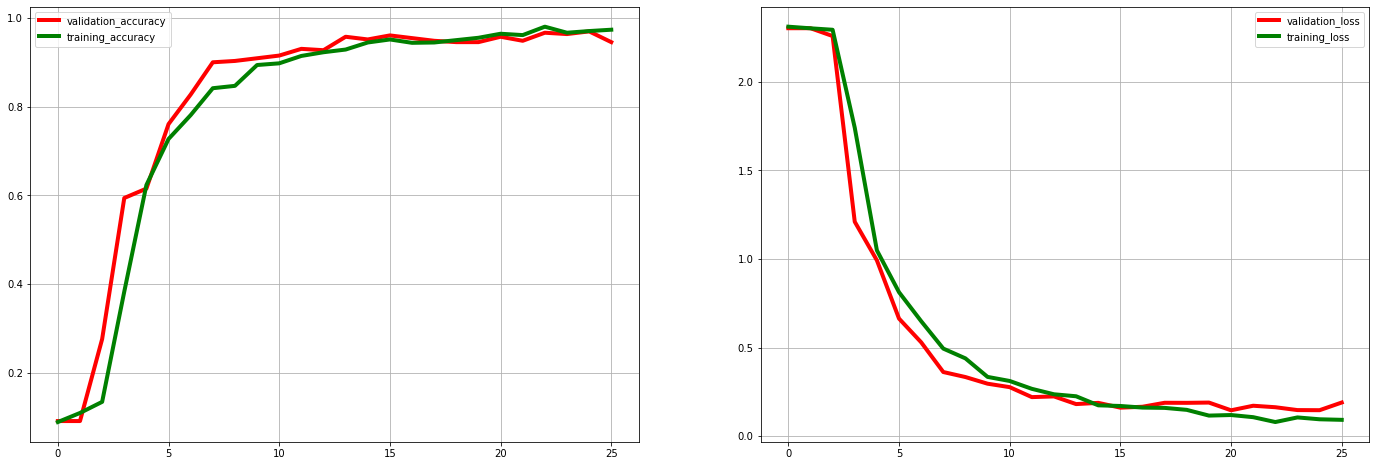

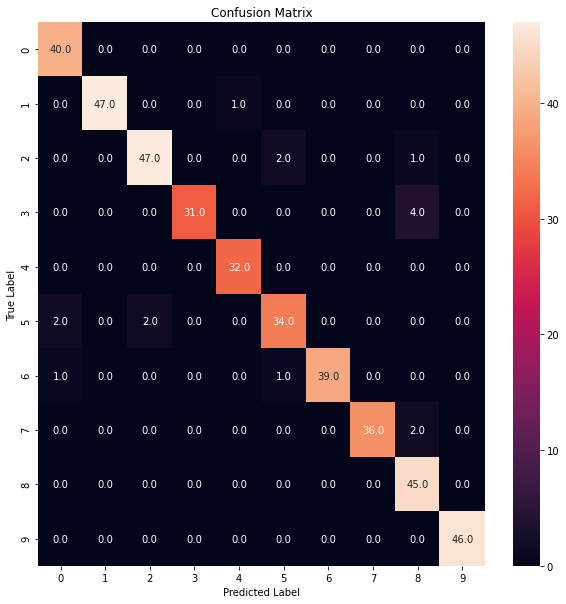

<Figure size 432x288 with 0 Axes>

Epoch 1/100
42/42 [==============================] - 7s 130ms/step - loss: 2.3173 - accuracy: 0.1183 - val_loss: 2.3022 - val_accuracy: 0.0939
Epoch 2/100
42/42 [==============================] - 6s 139ms/step - loss: 2.3038 - accuracy: 0.1031 - val_loss: 2.3030 - val_accuracy: 0.0879
Epoch 3/100
42/42 [==============================] - 6s 137ms/step - loss: 2.2961 - accuracy: 0.1221 - val_loss: 2.2636 - val_accuracy: 0.1333
Epoch 4/100
42/42 [==============================] - 7s 163ms/step - loss: 1.8602 - accuracy: 0.3677 - val_loss: 1.8385 - val_accuracy: 0.3182
Epoch 5/100
42/42 [==============================] - 6s 141ms/step - loss: 1.3564 - accuracy: 0.5133 - val_loss: 1.1680 - val_accuracy: 0.6030
Epoch 6/100
42/42 [==============================] - 6s 154ms/step - loss: 1.0271 - accuracy: 0.6323 - val_loss: 0.7874 - val_accuracy: 0.7394
Epoch 7/100
42/42 [==============================] - 5s 116ms/step - loss: 0.7909 - accuracy: 0.7362 - val_loss: 0.8949 - val_accuracy: 0.6576

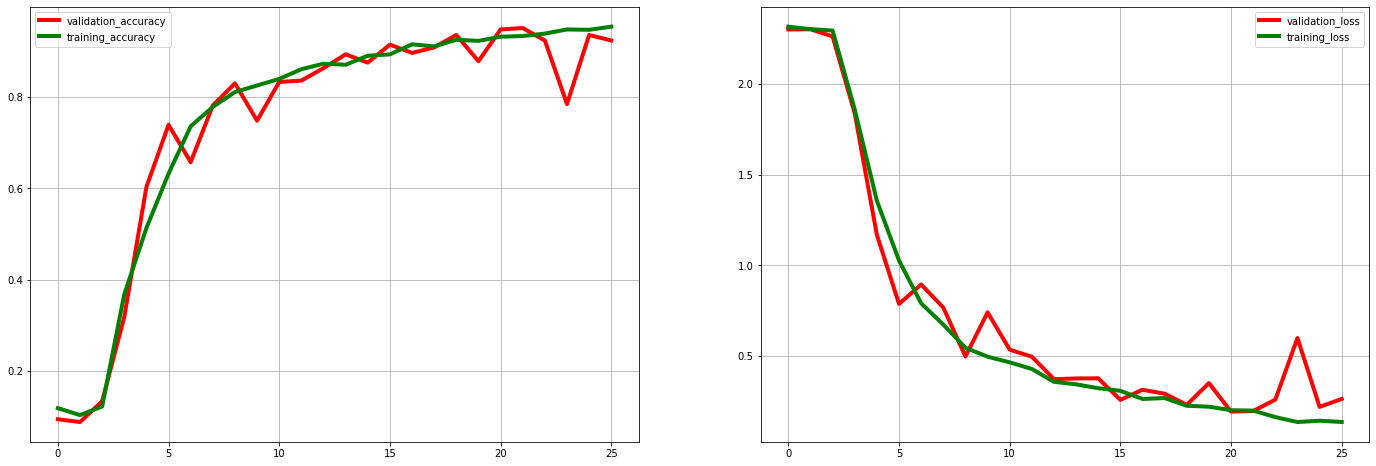

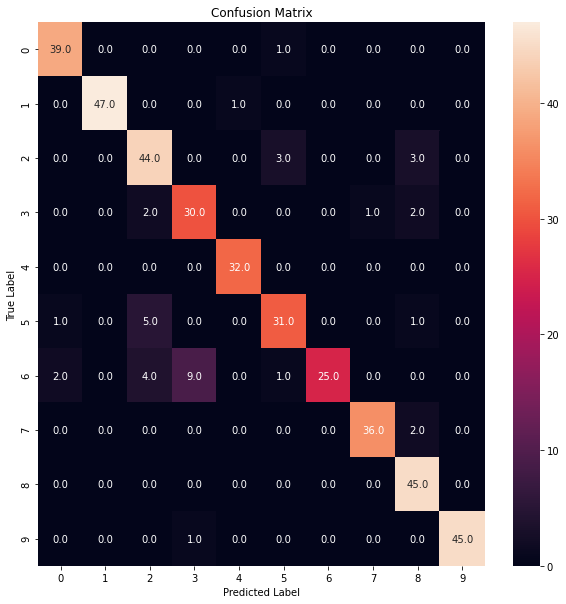

<Figure size 432x288 with 0 Axes>

In [11]:
for opt in optimizers:
    model.compile(optimizer = opt, loss = "categorical_crossentropy", metrics=["accuracy"])


    early_stopping = EarlyStopping(patience=5, monitor="val_loss")
    model.save_weights('model1')
    history = model.fit(x_train,y_train,validation_split = 0.2, epochs=100,callbacks=[MetricsCheckpoint('logs'),early_stopping])
    score = model.evaluate(x_test,y_test, verbose=0)
    
    print('\nKeras CNN - accuracy:', score[1], '\n')
    plt.figure(figsize=(24,8))

    plt.subplot(1,2,1)
    plt.plot(history.history["val_accuracy"], label="validation_accuracy", c="red", linewidth=4)
    plt.plot(history.history["accuracy"], label="training_accuracy", c="green", linewidth=4)
    plt.legend()
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(history.history["val_loss"], label="validation_loss", c="red", linewidth=4)
    plt.plot(history.history["loss"], label="training_loss", c="green", linewidth=4)
    plt.legend()
    plt.grid(True)
    y_predict = model.predict(x_test)
    y_predict_classes = np.argmax(y_predict,axis = 1) 
    y_true = np.argmax(y_test,axis = 1) 
    confusion_mtx = confusion_matrix(y_true, y_predict_classes) 
    plt.figure(figsize = (10,10))
    sns.heatmap(confusion_mtx, annot=True,fmt= '.1f')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    plt.suptitle("ACC / LOSS",fontsize=18)

    plt.show()

    # reseting weights
    
    model.load_weights('model1')

# Summary 

The Optimizer Adam seems to be the winner in this short study in finding the optimal solution to the classification problem. Already around the fifth epoch, its accuracy drastically increases with a simultaneous visible decrease in losses. For both sets - test and training, the values are similar, cl suggests no problem with overfitting. To achieve accuracy: 0.96, the model took 25 epochs at patience = 5. The confusion matrix indicates that 14 photos were misclassified.

In the case of the MRSProp classifier, the results are slightly worse. The confusion matrix shows 38 misclassified examples, and the accuracy and loss plots look more chaotic. The training_accuracy and validation_accuracy plots show more fluctuations

# Bibliography

[1] https://kaggle.com/ardamavi/Sign-Language-Digits-Dataset
[2] https://towardsdatascience.com/learning-parameters-part-5-65a2f3583f7d